In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import time




def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [2]:
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 365 * 24 *4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   
2      148.0      -15.0       -4.0     1020.0        2.0       2.68   
3      159.0      -11.0       -5.0     1021.0        2.0       3.57   
4      181.0       -7.0       -5.0     1022.0        2.0       5.36   
5      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-1)  var8(t-1)  var1(t)  
1        0.0        0.0    148.0  
2        0.0        0.0    159.0  
3        0.0        0.0    181.0  
4        1.0        0.0    138.0  
5        2.0        0.0    109.0  


In [5]:
model = tf.keras.Sequential([keras.layers.Dense(units=10, input_shape=[8]),keras.layers.Dense(units=5, input_shape=[10]), keras.layers.Dense(units=1, input_shape=[5])])

model.compile(optimizer='adam', loss='mae')

start = time.time()


model.fit(train_X, train_y, epochs=50)
end = time.time()
print('This took {} seconds.'.format(end - start))

y_pred = model.predict(test_X)

Epoch 1/50
35040/35040 [==============================] - 3s 73us/sample - loss: 0.0259
Epoch 2/50
35040/35040 [==============================] - 2s 55us/sample - loss: 0.0141
Epoch 3/50
35040/35040 [==============================] - 2s 54us/sample - loss: 0.0142
Epoch 4/50
35040/35040 [==============================] - 2s 56us/sample - loss: 0.0141
Epoch 5/50
35040/35040 [==============================] - 2s 69us/sample - loss: 0.0142
Epoch 6/50
35040/35040 [==============================] - 2s 56us/sample - loss: 0.0142
Epoch 7/50
35040/35040 [==============================] - 2s 55us/sample - loss: 0.0142
Epoch 8/50
35040/35040 [==============================] - 2s 56us/sample - loss: 0.0140
Epoch 9/50
35040/35040 [==============================] - 2s 55us/sample - loss: 0.0140
Epoch 10/50
35040/35040 [==============================] - 2s 55us/sample - loss: 0.0141
Epoch 11/50
35040/35040 [==============================] - 2s 55us/sample - loss: 0.0141
Epoch 12/50
35040/35040 [=====

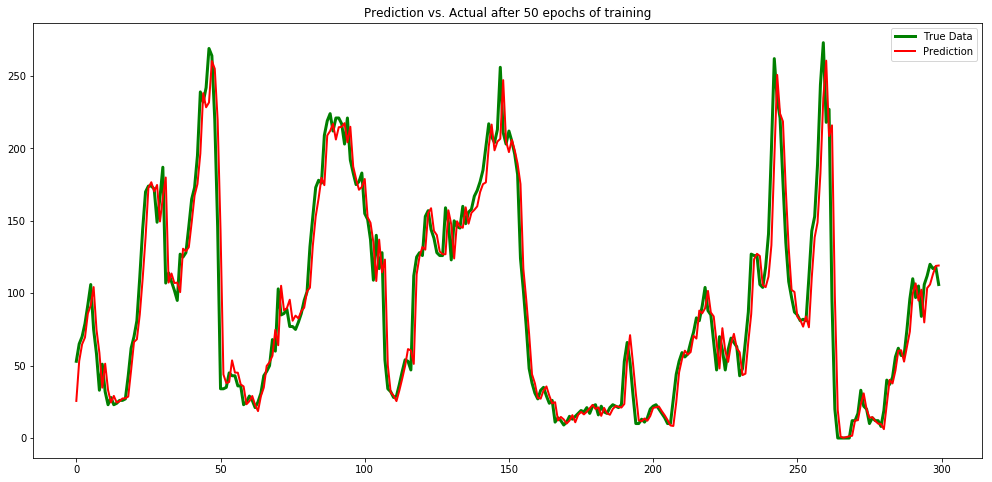

Root Mean Squared Error: 0.0245
R2 score : 0.93


In [4]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 50 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()
    
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
test_y = scaler.inverse_transform(test_y.reshape(-1,1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    
    
plot_predicted(y_pred[:300,], test_y[:300,])
print('Root Mean Squared Error: {:.4f}'.format(rmse))
print("R2 score : %.2f" % r2_score(test_y,y_pred))
